In [1]:
setwd('/lila/home/panb2/PRINT_original/PRINT/analyses/BMMCTutorial')

In [3]:
# If running in Rstudio, set the working directory to current path
if (Sys.getenv("RSTUDIO") == "1"){ setwd(dirname(rstudioapi::getActiveDocumentContext()$path))
}
source("../../code/utils.R")
source("../../code/getCounts.R")
source("../../code/getBias.R")
source("../../code/getFootprints.R")
source("../../code/getSubstructures.R")
source("../../code/visualization.R")
source("../../code/getGroupData.R")
source("../../code/footprintTracking.R")
source("../../code/getTFBS.R")

In [4]:
projectName <- "Prostate_replicate"
project <- footprintingProject(projectName = projectName,
                               refGenome = "hg38")
projectMainDir <- "../../"
projectDataDir <- "/data/peer/panb2/replicate/"
dataDir(project) <- projectDataDir
mainDir(project) <- projectMainDir

In [5]:
regionsBed <- read.table(paste0(projectDataDir, "CRE_regions.bed"), header = T)
regions <- GRanges(seqnames = regionsBed$chr,
                   ranges = IRanges(start = regionsBed$start, end = regionsBed$end))
regionRanges(project) <- regions

In [6]:
if(file.exists(paste0(projectDataDir, "predBias.rds"))){ 
    regionBias(project) <- readRDS(paste0(projectDataDir, "predBias.rds"))
}else{
    project <- getPrecomputedBias(project, nCores = 16) 
    saveRDS(regionBias(project), paste0(projectDataDir, "predBias.rds"))
}

In [7]:
pathToFragGrouping <- paste0(projectDataDir, "barcode_groups.txt")
barcodeGroups <- read.table(pathToFragGrouping, header = T)
barcodeGrouping(project) <- barcodeGroups
groups(project) <- mixedsort(unique(barcodeGroups$group))

In [8]:
pathToFrags <- paste0(projectDataDir, "/atac_fragments_added_chr.tsv")
project <- getCountTensor(project, pathToFrags, barcodeGroups, returnCombined = F)

[1] "Using chunk size = 2000"
Make 1bp step .. 
Reading in fragment file ..
Reading only select barcodes specified within list from file ..
Reformating counts data into a list (each element is data for a region) ..
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.216298 Processing chunk 1 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.218085 Processing chunk 2 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.218739 Processing chunk 3 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.219306 Processing chunk 4 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.219842 Processing chunk 5 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.220435 Processing chunk 6 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "2024-04-29 15:14:43.221059 Processing chunk 7 out of 180 chunks"
[1] "Re-organizing data into lists"
[1] "20

In [9]:
groupInfo <- read.table(paste0(projectDataDir, "groupInfo2.txt"), header = T,
                        comment.char = "")
groupCellType(project) <- groupInfo$cellType # Please make sure at least you provide this

In [10]:
for(kernelSize in 2:100){
    dispModel(project, as.character(kernelSize)) <- readRDS(paste0("../../data/shared/dispModel/dispersionModel", kernelSize, "bp.rds"))
}

In [11]:
# Load TFBS prediction model
h5Path <- "../../data/TFBSPrediction/TFBS_model.h5"
TFBindingModel(project) <- loadTFBSModel(h5Path)

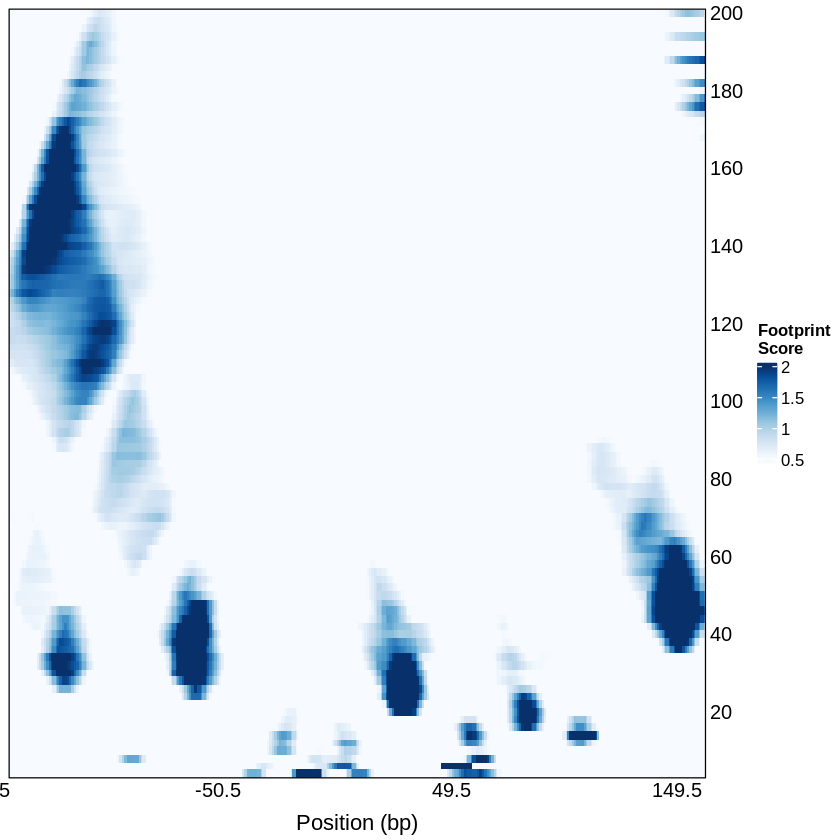

In [14]:
plotMultiScale(project = project, regionInd = 7)

In [12]:
produce_regional_result_tensor <- function(project, regionInd, footprintRadius=50){
    
    # Load predicted Tn5 bias track and width
    Tn5Bias <- regionBias(project)[regionInd, ]
    width <- regionWidth(project)
    
    # Retrieve Tn5 insertion count tensor for the corresponding chunk
    ret <- getCountData(project, regionInd)
    countData <- ret[["countData"]]
    adjustedRegionInd <- ret[["regionInd"]]
    
    # Determine the number of groups (clusters)
    groupIDs <- groups(project)
    num_groups <- length(groupIDs)
    
    # Pre-allocate a matrix to store the results
    regional_result <- matrix(nrow = num_groups, ncol = width[regionInd])

    # Loop over all clusters and compute footprints
    for (i in seq_along(groupIDs)){
        groupID <- groupIDs[i]
        
        # Get position-by-pseudobulk ATAC insertion matrix for each group
        regionATAC <- getRegionATAC(countData, adjustedRegionInd, groupID, width[regionInd])
        
        # Compute footprints
        footprintPvals <- footprintScoring(
            Tn5Insertion = rowSums(regionATAC),
            Tn5Bias = Tn5Bias,
            dispersionModel = dispModel(project, as.character(footprintRadius)),
            footprintRadius = footprintRadius,
            flankRadius = footprintRadius
        )
        
        # Calculate footprint scores and store them in the matrix
        footprintScores <- -log10(footprintPvals)
        regional_result[i, ] <- footprintScores
    }

    # Return the matrix of footprint scores
    return(regional_result)
}

In [13]:
num_regions <- 359263
num_groups <- 25
region_width <- 501 

# Pre-allocate a 3D tensor
result_tensor <- array(dim = c(num_regions, num_groups, region_width))

In [ ]:
suppressWarnings({
  # Loop over the region indices
  for (j in 1:num_regions) {
    message(j)
      
    # Assuming the function produce_regional_result_tensor has been debugged and returns a matrix
    regional_result_tensor <- produce_regional_result_tensor(project, j, footprintRadius=50)

    # Store the matrix in the corresponding slice of the 3D tensor
    result_tensor[j,,] <- regional_result_tensor
  }

  # The variable regional_result_tensor is now a 3D tensor containing all the matrices
})

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221

222

In [ ]:
dim(result_tensor)

In [ ]:
np <- import("numpy")
np$save("/data/peer/panb2/replicate/result_tensor.npy", result_tensor)